In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import torch

from importlib import reload
import utils

reload(utils)
from utils import evaluate_model

In [5]:
sarcasm_df = pd.read_csv("data/train-balanced-sarcasm.csv")

## Data Exploration

In [6]:
sarcasm_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


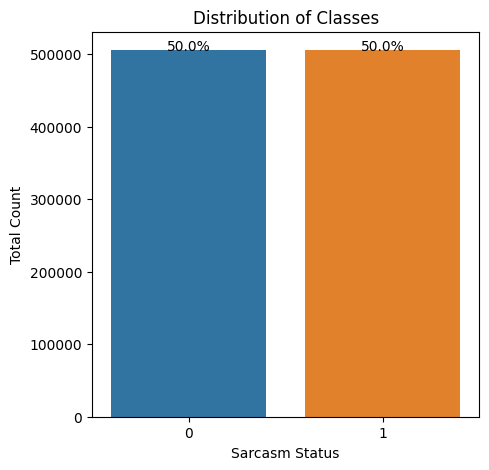

In [6]:
plt.figure(figsize=(5, 5))
ax = sns.countplot(x="label", data=sarcasm_df)
ax.set(title="Distribution of Classes", xlabel="Sarcasm Status", ylabel="Total Count")
total = float(len(sarcasm_df))
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 3,
        "{:1.1f}%".format((height / total) * 100),
        ha="center",
    )
plt.show()

In [7]:
sarcasm_df["subreddit"].value_counts()[:5]

AskReddit          65677
politics           39496
worldnews          26377
leagueoflegends    21037
pcmasterrace       18988
Name: subreddit, dtype: int64

In [5]:
top_reddits = ["AskReddit", "politics", "worldnews", "leagueoflegends", "pcmasterrace"]

subreddit_df = pd.DataFrame()
subreddit_df["subreddit"] = top_reddits
subreddit_df["sarcastic"] = np.nan
subreddit_df["natural"] = np.nan
subreddit_df["total"] = np.nan

# Calculating the count of Sarcastic and Natural comments for the top 5 subreddits
for i in range(len(top_reddits)):
    temp = sarcasm_df.loc[
        sarcasm_df["subreddit"] == subreddit_df.subreddit.iloc[i]
    ].copy()
    length = len(temp)
    count_sarcastic = len(temp.loc[temp["label"] == 1])
    subreddit_df.loc[i, "sarcastic"] = count_sarcastic
    subreddit_df.loc[i, "natural"] = length - count_sarcastic
    subreddit_df.loc[i, "total"] = length

In [9]:
subreddit_df

,subreddit,sarcastic,natural,total
0,AskReddit,26367.0,39310.0,65677.0
1,politics,23910.0,15586.0,39496.0
2,worldnews,16948.0,9429.0,26377.0
3,leagueoflegends,11409.0,9628.0,21037.0
4,pcmasterrace,10760.0,8228.0,18988.0


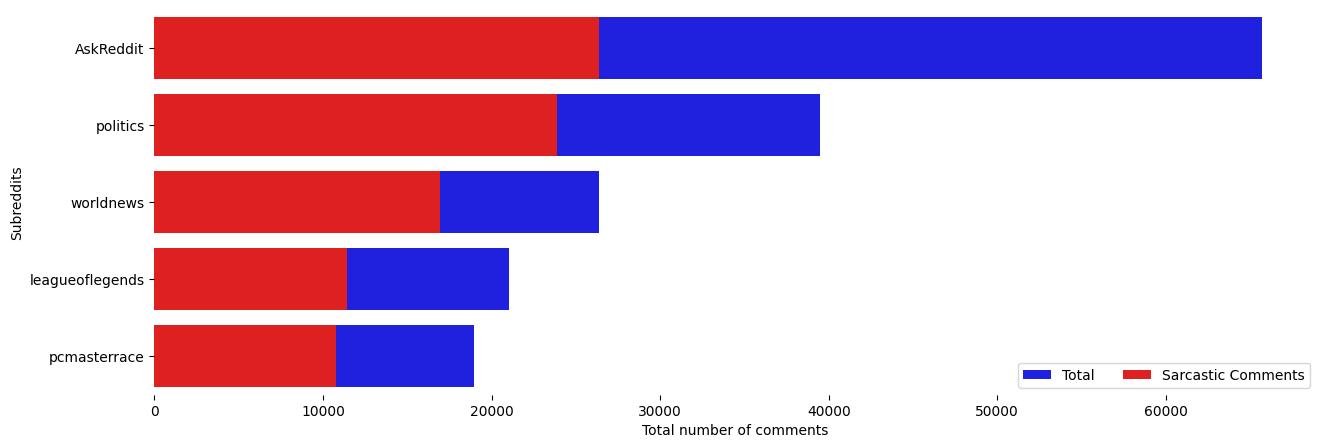

In [10]:
f, ax = plt.subplots(figsize=(15, 5))
# Plot the total comments for the subreddits
sns.barplot(x="total", y="subreddit", data=subreddit_df, label="Total", color="b")
# Plot the total sarcastic comments for the subreddits
sns.barplot(
    x="sarcastic",
    y="subreddit",
    data=subreddit_df,
    label="Sarcastic Comments",
    color="r",
)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Subreddits", xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

## Data Preparation / Preprocessing

In [7]:
# We just need comment & label columns
# So, let's remove others.
sarcasm_df.drop(
    [
        "author",
        "subreddit",
        "score",
        "ups",
        "downs",
        "date",
        "created_utc",
        "parent_comment",
    ],
    axis=1,
    inplace=True,
)
# remove empty rows
sarcasm_df.dropna(inplace=True)
sarcasm_df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [8]:
# Here we inspect data for missing values
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   label    1010773 non-null  int64 
 1   comment  1010773 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.1+ MB


In [9]:
# Some comments are missing, so we drop the corresponding rows.
sarcasm_df.dropna(subset=["comment"], inplace=True)

In [10]:
from preprocessing import preprocess

sarcasm_df["comment"] = sarcasm_df["comment"].apply(preprocess)

In [11]:
# Now we compare the number of instances for each class (1 - sarcasm, 0 - not sarcasm). We can see, that the dataset is balanced and classes have almost the same size
sarcasm_df["label"].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    sarcasm_df["comment"], sarcasm_df["label"], test_size=0.3, random_state=42
)

## Feature Encoding and Model Training

### TF-IDF Vectorizer

In [13]:
# create tf-idf encoder
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# encode training data
train_features = tf_idf.fit_transform(x_train)
# encode test data
test_features = tf_idf.transform(x_test)


### GloVe Embeddings

In [36]:
# load the GloVe embeddings from a text file
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings


# function that returns the mean of the word embeddings for a sentence
def glove_mean(sentence, embeddings, dim=100):
    words = sentence.split()
    vectors = np.zeros((len(words), dim))
    for i, word in enumerate(words):
        if word in embeddings:
            vectors[i] = embeddings[word]
    # check if vectors is empty or contains nan values
    if np.isnan(vectors).any() or len(vectors) == 0:
        # replace with zeros or random numbers
        return np.zeros(dim)
        # return np.random.rand(dim)
    else:
        return np.mean(vectors, axis=0)


# load the GloVe embeddings
glove_file = "glove.6B.100d.txt"
glove_embeddings = load_glove_embeddings(glove_file)

In [ ]:
# encode the training and test data using GloVe mean-pooling and convert them to PyTorch tensors
X_train_glove = torch.tensor(
    [glove_mean(sent, glove_embeddings) for sent in x_train], dtype=torch.float32
)
X_test_glove = torch.tensor(
    [glove_mean(sent, glove_embeddings) for sent in x_test], dtype=torch.float32
)

# convert Y_train and Y_test to PyTorch tensors
Y_train_glove = torch.tensor(y_train.values, dtype=torch.long)
Y_test_glove = torch.tensor(y_test.values, dtype=torch.long)


In [9]:
# convert the labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


## Statistical Learning Models

### Logistic Regression

In [20]:
# logistic regression model with tf-idf encoder
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(train_features, y_train)
pred_labels_log_reg = log_reg.predict(test_features)
print("Logistic regressio:")
evaluate_model(y_test, pred_labels_log_reg)

Logistic regression accuracy:  0.7177771475306036


In [16]:
C_range = [0.01, 0.1, 1, 10, 100]
best_f1, best_c = 0, 0
for C in C_range:
    clf_lr = LogisticRegression(random_state=0, solver="liblinear", C=C).fit(
        train_features, y_train
    )
    clf_lr.fit(train_features, y_train)
    y_pred = clf_lr.predict(test_features)
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_c = C
print("F1 Score for Logistic Regression is", best_f1)

F1 Score for Logistic Regression is 0.7070317046286978


In [ ]:
C_range = [0.01, 0.1, 1, 10, 100]
best_f1, best_c = 0, 0
for C in C_range:
    clf_lr = LogisticRegression(random_state=0, C=C, max_iter=1000).fit(
        train_features, y_train
    )
    clf_lr.fit(train_features, y_train)
    y_pred = clf_lr.predict(test_features)
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_c = C
print("Logistic Regression:")
print("Best C:", best_c)
evaluate_model(clf_lr, test_features, y_test)

### SVM (Linear Kernel)

In [47]:
C_range = [0.01, 0.1, 1, 10, 100]
best_f1, best_c = 0, 0
for C in C_range:
    svm_li = SVC(kernel="linear", C=C)
    svm_li.fit(train_features, y_train)
    y_pred = svm_li.predict(test_features)
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_c = C
print("Linear SVM:")
print("Best C:", best_c)
evaluate_model(svm_li, test_features, y_test)


### SVM (RBF Kernel)

In [ ]:
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [0.01, 0.1, 1, 10, 100]
best_f1, best_c, best_gamma = 0, 0, 0
for C in C_range:
    for gamma in gamma_range:
        svm_rbf = SVC(kernel="rbf", C=C, gamma=gamma)
        svm_rbf.fit(train_features, y_train)
        y_pred = svm_rbf.predict(test_features)
        if f1_score(y_test, y_pred) > best_f1:
            best_f1 = f1_score(y_test, y_pred)
            best_c = C
            best_gamma = gamma
print("RBF SVM:")
print("Best C:", best_c)
print("Best gamma:", best_gamma)


### Random Forest

Random Forest:
Best n_estimators:  98
Accuracy:  0.6314702933727311
F1 Score:  0.5475195568728439
Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.82      0.69    151387
           1       0.71      0.45      0.55    151845

    accuracy                           0.63    303232
   macro avg       0.65      0.63      0.62    303232
weighted avg       0.65      0.63      0.62    303232



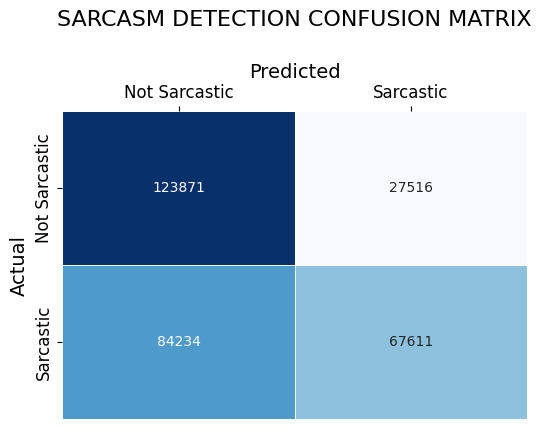

In [45]:
best_f1, best_n = 0, 0
for n_est in range(10, 100, 2):
    clf_rf = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=n_est)
    clf_rf.fit(train_features, y_train)
    y_pred = clf_rf.predict(test_features)
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_n = n_est
print("Random Forest:")
print("Best n_estimators: ", best_n)
evaluate_model(clf_rf, test_features, y_test)


### XGBoost

XGBoost:
Accuracy:  0.6815078883495146
F1 Score:  0.6344175975591752
Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.81      0.72    151387
           1       0.75      0.55      0.63    151845

    accuracy                           0.68    303232
   macro avg       0.69      0.68      0.68    303232
weighted avg       0.69      0.68      0.68    303232



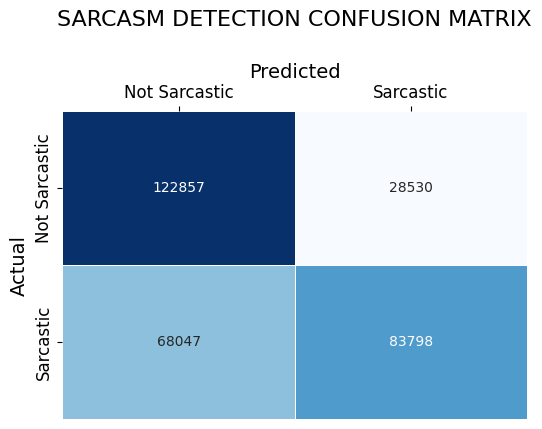

In [44]:
clf_xgboost = XGBClassifier()
clf_xgboost.fit(train_features, y_train)
print("XGBoost:")
evaluate_model(clf_xgboost, test_features, y_test)